Part A
### Num Nodes: 32 ###
Test loss: 4.046054287719727
Test accuracy: 0.06350000202655792

### Num Nodes: 64 ###
Test loss: 3.8311968078613283
Test accuracy: 0.10509999841451645

### Num Nodes: 96 ###
Test loss: 3.6309884017944336
Test accuracy: 0.14810000360012054

### Num Nodes: 100 ###
Test loss: 3.868130448913574
Test accuracy: 0.10660000145435333

### Num Nodes: 128 ###
Test loss: 3.833534938049316
Test accuracy: 0.11909999698400497

### Num Nodes: 160 ###
Test loss: 3.799606140136719
Test accuracy: 0.12870000302791595


Best Node Selection: 96


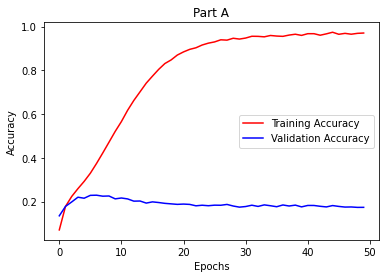

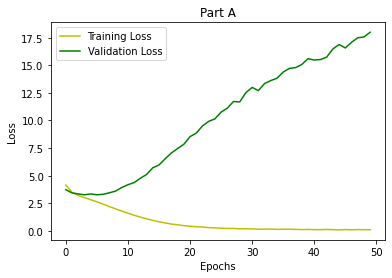

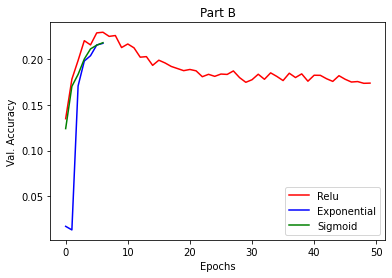

Part C
Max Accuracy class #: 60 - 0.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.470.47


TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [4]:
import numpy as np
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

if "__main__" == __name__:
    # config
    batch_size = 50
    img_width, img_height, img_num_channels = 32, 32, 3
    loss_function = sparse_categorical_crossentropy
    no_classes = 100
    no_epochs = 50
    optimizer = Adam()
    validation_split = 0.2
    verbosity = 0

    num_nodes = [32, 64, 96, 100, 128, 160]

    # load data
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')
    np.load = np_load_old

    input_shape = (img_width, img_height, img_num_channels)

    # Parse numbers as floats
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Normalize data
    X_train = X_train / 255
    X_test = X_test / 255

    print('Part A')
    num_nodes_results = []
    for i in num_nodes:
        # Create the model
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(Flatten())
        model.add(Dense(i, activation='relu'))
        model.add(Dense(i, activation='relu'))
        model.add(Dense(no_classes, activation='softmax'))

        # Compile the model
        model.compile(loss=loss_function,
                    optimizer=optimizer,
                    metrics=['accuracy'])

        # Fit data to model
        history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=1,
                verbose=verbosity,
                validation_split=validation_split)
        pred = np.argmax(model.predict(X_test), axis=1)
        
        # Generate generalization metrics

        score = model.evaluate(X_test, y_test, verbose=0)
        num_nodes_results.append(score[1])
        print("### Num Nodes: " + str(i) + " ###")
        print(f'Test loss: {score[0]}')
        print(f'Test accuracy: {score[1]}\n')

    best_node_num = num_nodes[num_nodes_results.index(max(num_nodes_results))]
    print("\nBest Node Selection: " + str(best_node_num))


    # Find most ideal epoch
    # Create the model
    model_relu = Sequential()
    model_relu.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model_relu.add(Flatten())
    model_relu.add(Dense(best_node_num, activation='relu'))
    model_relu.add(Dense(best_node_num, activation='relu'))
    model_relu.add(Dense(no_classes, activation='softmax'))

    # Compile the model
    model_relu.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])

    # Fit data to model
    history_relu = model_relu.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)
    pred_relu = np.argmax(model_relu.predict(X_test), axis=1)

    plt.clf()
    acc = history_relu.history['acc']
    val_acc = history_relu.history['val_acc']
    plt.plot(range(len(acc)), acc,'r',label='Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation Accuracy')
    plt.title('Part A')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.clf()
    loss = history_relu.history['loss']
    val_loss = history_relu.history['val_loss']
    plt.plot(range(len(loss)), loss,'y',label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, 'g', label='Validation Loss')
    plt.title('Part A')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    best_epoch_num = history_relu.history['val_acc'].index(max(history_relu.history['val_acc'])) + 1

    # Exponential activation
    # Use most ideal epoch
    # Create the model
    model_exp = Sequential()
    model_exp.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model_exp.add(Flatten())
    model_exp.add(Dense(best_node_num, activation='relu'))
    model_exp.add(Dense(best_node_num, activation='relu'))
    model_exp.add(Dense(no_classes, activation='exponential'))

    # Compile the model
    model_exp.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])

    # Fit data to model
    history_exp = model_exp.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=best_epoch_num,
            verbose=verbosity,
            validation_split=validation_split)
    pred_exp = np.argmax(model_exp.predict(X_test), axis=1)


    # Sigmoid activation
    # Use most ideal epoch
    # Create the model
    model_sigmoid = Sequential()
    model_sigmoid.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model_sigmoid.add(Flatten())
    model_sigmoid.add(Dense(best_node_num, activation='relu'))
    model_sigmoid.add(Dense(best_node_num, activation='relu'))
    model_sigmoid.add(Dense(no_classes, activation='sigmoid'))

    # Compile the model
    model_sigmoid.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])

    # Fit data to model
    history_sigmoid = model_sigmoid.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=best_epoch_num,
            verbose=verbosity,
            validation_split=validation_split)
    pred_sigmoid = np.argmax(model_sigmoid.predict(X_test), axis=1)

    plt.clf()
    relu_acc = history_relu.history['val_acc']
    exp_acc = history_exp.history['val_acc']
    sigmoid_acc = history_sigmoid.history['val_acc']
    plt.plot(range(len(relu_acc)), relu_acc,'r',label='Relu')
    plt.plot(range(len(exp_acc)), exp_acc, 'b', label='Exponential')
    plt.plot(range(len(sigmoid_acc)), sigmoid_acc, 'g', label='Sigmoid')
    plt.title('Part B')
    plt.xlabel('Epochs')
    plt.ylabel('Val. Accuracy')
    plt.legend()
    plt.show()

    max_relu_acc = max(history_relu.history['val_acc'])
    max_exp_acc = max(history_exp.history['val_acc'])
    max_sigmoid_acc = max(history_sigmoid.history['val_acc'])

    fin_pred = []
    if(max_relu_acc >= max_exp_acc and max_relu_acc >= max_sigmoid_acc):
            fin_pred = pred_relu   
    elif(max_exp_acc >= max_relu_acc and max_exp_acc >= max_sigmoid_acc):
            fin_pred = pred_exp  
    else:
            fin_pred = pred_sigmoid 

    cm = confusion_matrix(y_test, fin_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm.diagonal()

    max_acc = class_acc.argmax(axis=0)
    min_acc = class_acc.argmin(axis=0)
    print('Part C')
    print("Max Accuracy class #: " + str(max_acc) + " - " + str(class_acc[max_acc]) * 100) + "%"
    print("Min Accuracy class #: " + str(min_acc) + " - " + str(class_acc[min_acc]) * 100) + "%"

